In [57]:
from sde import *
import mixture

1. Generate directed graph with randomly weighted edges AND randomly weighted nodes (these will be the observed nodes)
2. Add unweighted nodes (the hidden/unobserved nodes) to the graph 

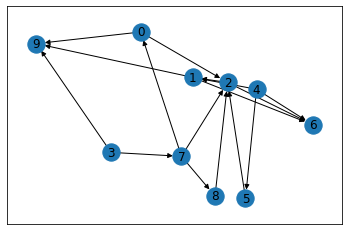

In [58]:
# current node function
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

# a DAG with weighted edges and unweighted nodes
dg = makeDirectedGraph(10, 24)
nx.draw_networkx(dg)

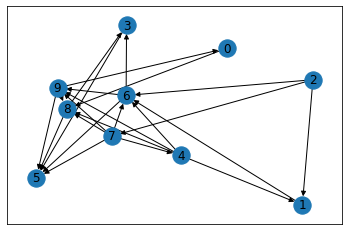

In [59]:
# add weighted nodes
def addWeightedNodes(gm, num_nodes):
    node_list = []
    observed_nodes = int(num_nodes*.5)  # half of the total nodes are observed
    hidden_nodes = num_nodes - observed_nodes # the remaining nodes are hidden
    
    
    for i in range(observed_nodes):
        random_prob = random.random()
        #nx.set_node_attributes(gm, random_prob, 'weight')
        
        gm.add_node(i, weight=random_prob)
        
    for i in range(hidden_nodes):
        gm.add_node(i)

    return gm

def makeWeightedDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addWeightedNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg


# a DAG with weighted edges and weighted observed nodes
dg2 = makeWeightedDirectedGraph(10, 50)
nx.draw_networkx(dg2)

In [60]:
node_weights = nx.get_node_attributes(dg2, 'weight')
node_weights

{0: 0.7118131269919409,
 1: 0.13702140443530808,
 2: 0.4209302268759365,
 3: 0.2603364563004049,
 4: 0.19990049107829544}

create a subset for each observed (weighted) node containing neighbors and non-d-separated nodes

In [61]:
#make a list of each weighted/observed node
obsNodes = [obs for obs in list(node_weights.keys())]
obsNodes

[0, 1, 2, 3, 4]

In [62]:
print(list(dg.successors(9)))

[]


In [63]:
# get all node neighbors (parents and children)
# nx.all_neighbors(dg, node) - iterates through all neighbors of specified node
# print(list(dg2.neighbors(0)))
# non d-separated: share a descendant or child node

def getSubset(dg, observed_node):
    """accepts a graph and node name, returns a list of that node's neighbors and non-d-separated nodes
        (includes the original node also)"""
    #get all neighbors
    children = list(dg.successors(observed_node))
    parents = list(dg.predecessors(observed_node))
    
    #get all non-d-separated nodes
    non_d_separated = []
    for n in list(dg.nodes()):
        n_children = list(dg.predecessors(n))
        commonDescendants = list(set(children) & set(n_children))
        if commonDescendants:
            non_d_separated += commonDescendants
            
    node_subset = [observed_node] + children + parents + commonDescendants
    return node_subset

In [64]:
subsets = {}
for node in obsNodes:
    nodeSubset = getSubset(dg2, node)
    subsets[node] = nodeSubset

In [65]:
print(subsets)

{0: [0, 8, 9], 1: [1, 6, 2, 4], 2: [2, 1, 6, 7, 7], 3: [3, 5, 6, 8], 4: [4, 6, 8, 1, 9, 7, 9]}


iterating through each node: 
1. assign interval-valued marginal likelihood ot vacuous messages
2. calculate interval-valued marginal probability for other hidden nodes using Annihilation/Reinforcement

create functions for both 1 and 2

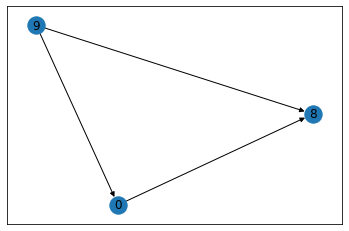

In [66]:
# for each observed node, create a subgraph of it's and its corresponding node set

testsub = dg2.subgraph(subsets.get(0))
nx.draw_networkx(testsub)

In [67]:
node_weights = nx.get_node_attributes(testsub, 'weight')
node_weights

{0: 0.7118131269919409}

In [68]:
edge_weights = nx.get_edge_attributes(testsub, 'weight')
edge_weights

{(0, 8): 0.34017953343411456,
 (9, 0): 0.27110020214011554,
 (9, 8): 0.046361009002752196}

In [69]:
# find all hidden (i.e. unweighted) nodes

def getHiddenNodes(dg):
    """accepts graph, returns list of nodes with no attached weight"""
    hidden_nodes = []
    dict_weights = nx.get_node_attributes(dg, 'weight')
    obsNodes = list(dict_weights.keys())
    
    for n in list(dg.nodes()):
        if (n not in obsNodes):
            hidden_nodes.append(n)
            
    return hidden_nodes

In [70]:
hiddenList = getHiddenNodes(testsub)
print(hiddenList)

[8, 9]


In [71]:
def minMargInterval(dg, hidden_node):
    """accepts a graph and specified unobserved node, returns the lower bound for that node's marginal likelihood interval"""
    
    observed_ancestors = list(testsub.predecessors(hidden_node))
    
    priorList = []
    cpList = []
    for n in observed_ancestors:
        n_weight_dict = nx.get_node_attributes(testsub, 'weight')
        n_weight = n_weight_dict.get(n)
        priorList.append(n_weight)

        e_weight_dict = nx.get_edge_attributes(testsub, 'weight')
        edge_weight = e_weight_dict.get((n, hidden_node))
        cpList.append(edge_weight)
    
        minMarg = numpy.prod(cpList)
        return minMarg
        

In [72]:
# get minimum marginal likelihood of a hidden node

# 1. use conditional probability and (product of) ancestor node edge weights to calculate minimum marginal likelihood 
"""for h in hiddenList:
    obsAnc = list(testsub.predecessors(h))
    print(obsAnc)"""

test_node = random.choice(hiddenList)

observed_ancestors = list(testsub.predecessors(test_node))
print(observed_ancestors)
    
    
priorList = []
cpList = []
for n in observed_ancestors:
    n_weight_dict = nx.get_node_attributes(testsub, 'weight')
    n_weight = n_weight_dict.get(n)
    priorList.append(n_weight)
    print(priorList)
    
    e_weight_dict = nx.get_edge_attributes(testsub, 'weight')
    edge_weight = e_weight_dict.get((n, test_node))
    cpList.append(edge_weight)
    print(cpList)
    
"""prior_dist = numpy.prod(priorList)  # product of all prior probs
print(prior_dist)"""

minMarg = numpy.prod(cpList)
print(minMarg)





[]
1.0


In [73]:
# 2. use conditional probability and (product of) ancestor node edge weights to calculate maximum marginal likelihood   
observed_descendants = list(testsub.successors(test_node))
print(observed_descendants)

descList = []
cpList = []
for n in observed_descendants:
    n_weight_dict = nx.get_node_attributes(testsub, 'weight')
    n_weight = n_weight_dict.get(n)
    descList.append(n_weight)
    print(descList)
    
    e_weight_dict = nx.get_edge_attributes(testsub, 'weight')
    edge_weight = e_weight_dict.get((test_node, n))
    cpList.append(edge_weight)
    print(cpList)
    
maxMarg = numpy.prod(cpList)
print(maxMarg)   #result might be None because if the node is a vacuous message

[0, 8]
[0.7118131269919409]
[0.27110020214011554]
[0.7118131269919409, None]
[0.27110020214011554, 0.046361009002752196]
0.012568478912065837
